In [13]:
import tensorflow as tf
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [44]:

endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=EUR&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')

# colonne cible
target_col = 'close'

# maj API, suppression des 2 colonnes string
hist = hist.drop(['conversionType','conversionSymbol'], axis=1)

In [45]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-12-01,52112.38,49983.41,50264.66,7375.60,3.746029e+08,50574.41
2021-12-02,50678.81,49311.27,50574.41,8639.37,4.326839e+08,50028.08
2021-12-03,50947.51,46309.21,50028.08,10946.58,5.366757e+08,47538.97
2021-12-04,47687.92,39085.63,47538.97,22729.36,9.723388e+08,43709.26
2021-12-05,44104.90,42340.33,43709.26,9112.00,3.960917e+08,43732.81


In [81]:
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# -- Define Binance Client --
client = Client()

# -- You can change the crypto pair ,the start date and the time interval below --
pairName = "BTCUSDT"
startDate = "01 january 2017"
timeInterval = Client.KLINE_INTERVAL_12HOUR

# -- Load all price data from binance API --
klinesT = client.get_historical_klines(pairName, timeInterval, startDate)

# -- Define your dataset --
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])
df['volume']=pd.to_numeric(df['volume'])

# -- Set the date to index --
df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']
print("Data loaded 100%")
df = df.drop(['close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'], axis=1)


Data loaded 100%


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4135 entries, 2017-08-17 00:00:00 to 2023-04-15 12:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    4135 non-null   float64
 1   high    4135 non-null   float64
 2   low     4135 non-null   float64
 3   close   4135 non-null   float64
 4   volume  4135 non-null   float64
dtypes: float64(5)
memory usage: 193.8 KB


In [83]:
# Extraction de la colonne 'close' et suppression du dataframe
close_col = df.pop('close')

# Ajout de la colonne 'close' à la fin du dataframe
df = df.assign(close=close_col)

# Affichage du dataframe modifié
print(df.head())

                        open     high      low      volume    close
timestamp                                                          
2017-08-17 00:00:00  4261.48  4485.39  4261.32  145.708747  4427.30
2017-08-17 12:00:00  4436.06  4485.39  4200.74  649.441630  4285.08
2017-08-18 00:00:00  4285.08  4371.52  4134.61  720.722201  4340.31
2017-08-18 12:00:00  4320.52  4340.31  3938.77  479.166063  4108.37
2017-08-19 00:00:00  4108.37  4184.69  3850.00  298.518569  3957.60


In [84]:
hist=df
target_col = 'close'

In [85]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = train_test_split(hist, test_size=0.2)

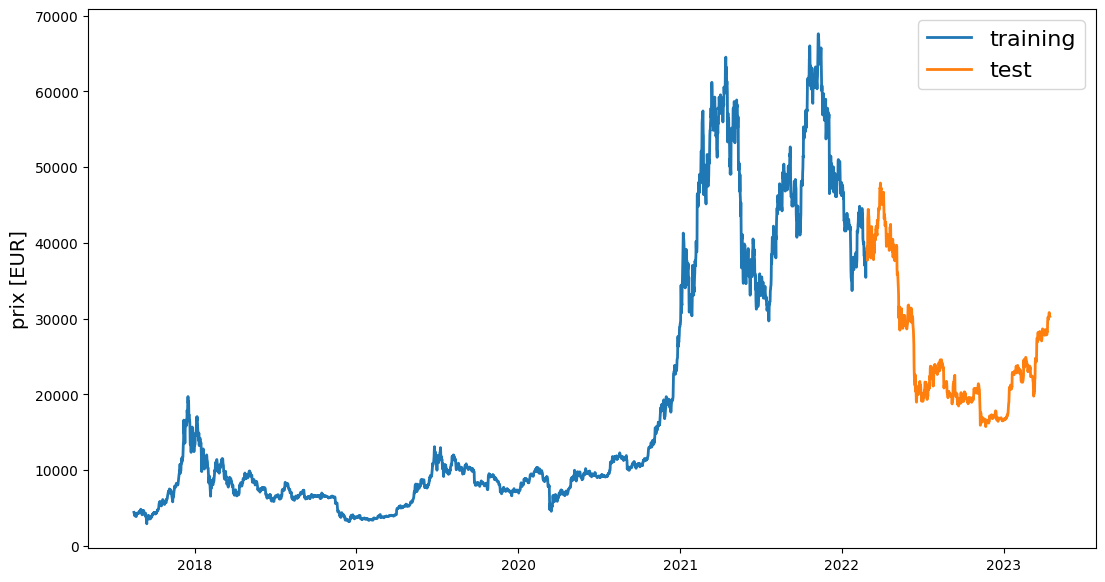

In [86]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('prix [EUR]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [87]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [88]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [89]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [97]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.models import Sequential

def build_lstm_model(neurons=100, dropout=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer=optimizer)
    return model

lstm_model = KerasRegressor(build_fn=build_lstm_model, epochs=20, batch_size=32, verbose=0)

# define the grid search parameters
param_grid = {'neurons': [50, 100, 150],
              'dropout': [0.1, 0.2, 0.3],
              'optimizer': ['adam', 'rmsprop']}

# define the grid search
grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, n_jobs=-1, cv=3)

# fit the grid search
grid_result = grid.fit(X_train, y_train)

# print the best parameters and the corresponding mean squared error
print("Best parameters: ", grid_result.best_params_)
print("Best MSE: ", grid_result.best_score_)


C:\Users\podoG\AppData\Local\Temp\ipykernel_4520\542898068.py:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasRegressor(build_fn=build_lstm_model, epochs=20, batch_size=32, verbose=0)


Best parameters:  {'dropout': 0.1, 'neurons': 100, 'optimizer': 'adam'}
Best MSE:  -0.0008667908453692993


In [98]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.1, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [99]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.1
optimizer = 'adam'

In [100]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
104/104 [==============================] - 4s 6ms/step - loss: 0.0025
Epoch 2/20
104/104 [==============================] - 1s 8ms/step - loss: 0.0015
Epoch 3/20
104/104 [==============================] - 1s 6ms/step - loss: 0.0013
Epoch 4/20
104/104 [==============================] - 1s 7ms/step - loss: 0.0012
Epoch 5/20
104/104 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 6/20
104/104 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 7/20
104/104 [==============================] - 1s 7ms/step - loss: 0.0010
Epoch 8/20
104/104 [==============================] - 1s 7ms/step - loss: 9.5955e-04
Epoch 9/20
104/104 [==============================] - 1s 7ms/step - loss: 9.3259e-04
Epoch 10/20
104/104 [==============================] - 1s 7ms/step - loss: 9.1550e-04
Epoch 11/20
104/104 [==============================] - 1s 7ms/step - loss: 9.0622e-04
Epoch 12/20
104/104 [==============================] - 1s 6ms/step - loss: 9.1011e-04
Epoch

In [101]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

26/26 [==============================] - 1s 3ms/step


0.014522575233044274

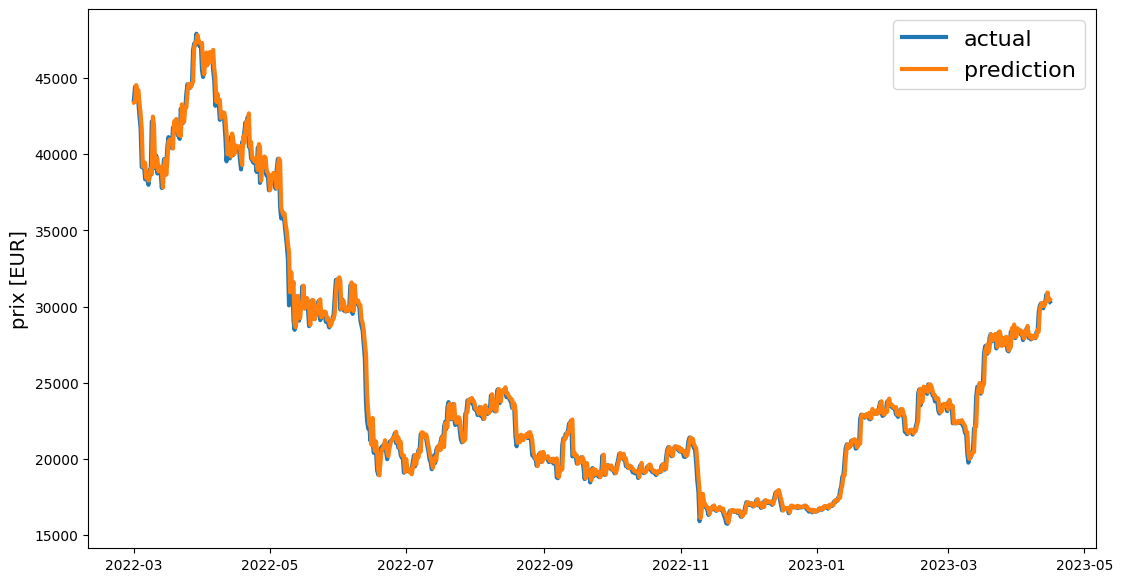

In [94]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

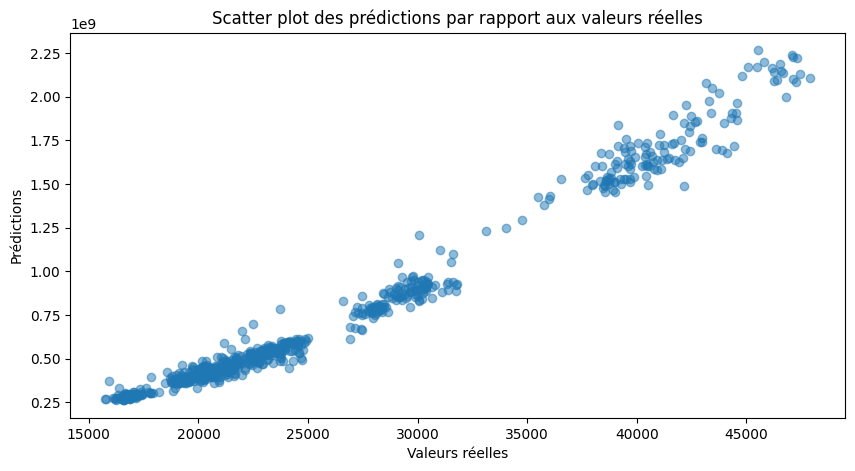

In [95]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(targets, preds, alpha=0.5)
ax.set_xlabel('Valeurs réelles')
ax.set_ylabel('Prédictions')
ax.set_title('Scatter plot des prédictions par rapport aux valeurs réelles')
plt.show()


In [105]:
# -- Récupération des données de prix les plus récentes --
pairName = "BTCUSDT"
startDate = "01 january 2017"
timeInterval = Client.KLINE_INTERVAL_12HOUR

klinesT = client.get_historical_klines(pairName, timeInterval, startDate)
df_new = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df_new['close'] = pd.to_numeric(df_new['close'])
df_new['high'] = pd.to_numeric(df_new['high'])
df_new['low'] = pd.to_numeric(df_new['low'])
df_new['open'] = pd.to_numeric(df_new['open'])
df_new['volume']=pd.to_numeric(df_new['volume'])


# -- Set the date to index --
df_new= df_new.set_index(df_new['timestamp'])
df_new.index = pd.to_datetime(df_new.index, unit='ms')
del df_new['timestamp']
print("Data loaded 100%")
df_new = df_new.drop(['close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'], axis=1)
# -- Préparation des données pour la prédiction --
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(df_new, 'close', window_len=window_len, zero_base=zero_base, test_size=0.0)

# -- Préparation des données pour la prédiction --
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

next_12h_df = df_new.iloc[-(window_len+1):-1].copy()
next_12h_X = np.array([next_12h_df.iloc[-window_len:, :-1]])
next_12h_X_norm = np.array([normalise_zero_base(next_12h_X[0])])


# -- Prédiction du prix dans 12 heures --
next_12h_y_pred = model.predict(next_12h_X_norm).squeeze()

# -- Dé-normalisation du résultat --
next_12h_y_pred_denorm = (next_12h_y_pred + 1) * df_new['close'].iloc[-window_len-1]

print("Le prix de Bitcoin à midi demain devrait être d'environ ", round(next_12h_y_pred_denorm, 2), " dollars.") 


Data loaded 100%


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

Data loaded 100%


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [130]:
# -- Récupération des données de prix les plus récentes --
pairName = "BTCUSDT"
startDate = "01 january 2017"
timeInterval = Client.KLINE_INTERVAL_12HOUR

klinesT = client.get_historical_klines(pairName, timeInterval, startDate)
df_new = pd.DataFrame(klinesT, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
df_new['close'] = pd.to_numeric(df_new['close'])
df_new['high'] = pd.to_numeric(df_new['high'])
df_new['low'] = pd.to_numeric(df_new['low'])
df_new['open'] = pd.to_numeric(df_new['open'])
df_new['volume'] = pd.to_numeric(df_new['volume'])

# -- Set the date to index --
df_new = df_new.set_index(df_new['timestamp'])
df_new.index = pd.to_datetime(df_new.index, unit='ms')
df_new = df_new[['open', 'high', 'low', 'volume', 'close']]


# -- Préparation des données pour la prédiction --
window_len = 5
next_12h_df = df_new.iloc[-(window_len+1):-1].copy()
next_12h_X = np.array([next_12h_df.iloc[-window_len:, :-1]])
train_mean = np.mean(X_train[:, :-1], axis=0)
train_std = np.std(X_train[:, :-1], axis=0)
next_12h_X_norm = (next_12h_X.transpose(0, 2, 1) - train_mean) / train_std

# -- Prédiction du prix dans 12 heures --
next_12h_y_pred = model.predict(next_12h_X_norm).squeeze()

# -- Dé-normalisation du résultat --
next_12h_y_pred_denorm = (next_12h_y_pred + 1) * df_new['close'].iloc[-window_len-1]
print("Le prix de Bitcoin à midi demain devrait être d'environ ", round(next_12h_y_pred_denorm, 2))


1/1 [==============================] - 0s 35ms/step
Le prix de Bitcoin à midi demain devrait être d'environ  nan


C:\Users\podoG\AppData\Local\Temp\ipykernel_4520\3053734349.py:26: RuntimeWarning: divide by zero encountered in divide
  next_12h_X_norm = (next_12h_X.transpose(0, 2, 1) - train_mean) / train_std


(1, 5, 4)
next_12h_df shape: (5, 5)
next_12h_X shape: (1, 5, 4)
train_mean shape: (4, 5)
train_std shape: (4, 5)
next_12h_X_norm shape: (1, 4, 5)


C:\Users\podoG\AppData\Local\Temp\ipykernel_4520\909219488.py:2: RuntimeWarning: divide by zero encountered in divide
  next_12h_X_norm = (next_12h_X.transpose(0, 2, 1) - train_mean) / train_std


In [112]:
df_new.head()

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807


In [120]:
next_12h

[[1680566400000,
  '27800.00000000',
  '28444.44000000',
  '27662.79000000',
  '28289.52000000',
  '26107.75348000',
  1680609599999,
  '732060540.61990410',
  575455,
  '13480.51535000',
  '378031969.11045420',
  '0'],
 [1680609600000,
  '28289.51000000',
  '28399.00000000',
  '27947.59000000',
  '28165.47000000',
  '23614.80343000',
  1680652799999,
  '665080924.25513200',
  526552,
  '11603.43699000',
  '326813433.30868670',
  '0'],
 [1680652800000,
  '28165.47000000',
  '28775.00000000',
  '28099.68000000',
  '28554.38000000',
  '26024.59131000',
  1680695999999,
  '742597322.76503960',
  539561,
  '13226.51007000',
  '377413237.28544160',
  '0'],
 [1680696000000,
  '28554.37000000',
  '28750.00000000',
  '27805.10000000',
  '28170.01000000',
  '34713.05601000',
  1680739199999,
  '978501216.30101710',
  723169,
  '17330.37665000',
  '488557852.88502660',
  '0'],
 [1680739200000,
  '28170.01000000',
  '28182.05000000',
  '27711.00000000',
  '27945.52000000',
  '19837.57217000',
  1

In [131]:
# -- Define Binance Client --
client = Client()

# -- Get ticker data for BTCUSDT --
ticker = client.get_ticker(symbol='BTCUSDT')

# -- Extract data from ticker --
last_price = float(ticker['lastPrice'])
bid_price = float(ticker['bidPrice'])
ask_price = float(ticker['askPrice'])

print("Last price:", last_price)
print("Bid price:", bid_price)
print("Ask price:", ask_price)


Last price: 30318.8
Bid price: 30318.8
Ask price: 30318.81
